In [98]:
import os
import faiss
import pdfplumber
import re
import networkx as nx
import matplotlib.pyplot as plt
import random
from openai import OpenAI
import time
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from IPython.display import display, Markdown
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel


In [99]:
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

In [100]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [101]:
def extract_text_from_pdfs(folder_path):
    documents = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            path = os.path.join(folder_path, filename)
            text = ""
            with pdfplumber.open(path) as pdf:
                for page in pdf.pages:
                    text += page.extract_text() + "\n"
            documents.append((filename, text))
    return documents

papers = extract_text_from_pdfs("./codecivil")
print(len(papers))

1


In [102]:
def chunk_text(text, chunk_size=500, overlap=50):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = " ".join(words[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

texts = []
metadata = []

for filename, content in papers:
    chunks = chunk_text(content)
    for i, chunk in enumerate(chunks):
        texts.append(chunk)
        metadata.append({"source": filename, "chunk": i})


In [103]:
print(len(chunks))
print(chunks[137])

451
d'exercer les fonctions de curateur ou de tuteur pour le cas où elle serait placée en curatelle ou en tutelle s'impose au juge, sauf si la personne désignée refuse la mission ou est dans l'impossibilité de l'exercer ou si l'intérêt de la personne protégée commande de l'écarter. En cas de difficulté, le juge statue. Il en est de même lorsque les parents ou le dernier vivant des père et mère, ne faisant pas l'objet d'une mesure de curatelle ou de tutelle, qui exercent l'autorité parentale sur leur enfant mineur ou assument la charge matérielle et affective de leur enfant majeur désignent une ou plusieurs personnes chargées d'exercer les fonctions de curateur ou de tuteur à compter du jour où eux-mêmes décéderont ou ne pourront plus continuer à prendre soin de l'intéressé. Article 449 A défaut de désignation faite en application de l'article 448, le juge nomme, comme curateur ou tuteur, le conjoint de la personne protégée, le partenaire avec qui elle a conclu un pacte civil de solidar

In [104]:
def get_embedding(text):
    return model.encode(text)
embeddings = np.array([get_embedding(t) for t in texts]).astype("float32")

In [105]:
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)
print(f"FAISS index crée avec {index.ntotal} chunks.")

FAISS index crée avec 451 chunks.


In [106]:
def search(query, k=5):
    query_embed = np.array(get_embedding(query)).astype("float32")
    D, I = index.search(np.array([query_embed]), k)
    return [(texts[i], metadata[i]) for i in I[0]]

In [109]:
def ask(query):
    results = search(query)
    context = "\n---\n".join([f"{meta['source']} [chunk {meta['chunk']}]:\n{text}" for text, meta in results])
    prompt = f"Tu es un assistant juridique. Utilise le contexte ci-dessous pour répondre à la question.\n\nContexte:\n{context}\n\nQuestion: {query}\nRéponse:"

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "Tu es un assistant juridique."},
            {"role": "user", "content": prompt}
        ]
    )
    answer = response.choices[0].message.content

    display(Markdown(f"**Question:** {query}"))
    display(Markdown(f"**Réponse :**\n{answer}"))
    display(Markdown("**Sources :**"))
    for text, meta in results:
        display(Markdown(f"- `{meta['source']} {text} [chunk {meta['chunk']}]`"))

ask("Est-ce que la vente parfaite implique que celui qui s’est déjà engagé ne peut vendre au plus offrant ?")

**Question:** Est-ce que la vente parfaite implique que celui qui s’est déjà engagé ne peut vendre au plus offrant ?

**Réponse :**
La vente parfaite est un concept juridique qui signifie que l'acheteur et le vendeur sont définitivement engagés l'un envers l'autre. En principe, une fois la vente parfaite réalisée, le vendeur ne peut pas vendre le bien à une autre personne, sauf accord contraire ou si une clause de réserve de propriété est prévue dans le contrat de vente. Cela signifie que, en principe, celui qui s'est déjà engagé dans une vente parfaite ne peut pas vendre au plus offrant.

**Sources :**

- `codecivil.pdf la dette garantie, une somme égale à la différence entre cette valeur et le montant de la dette, sous réserve du paiement préalable des dettes nées de la conservation ou de la gestion du patrimoine fiduciaire. Sous la même réserve, si le fiduciaire procède à la vente du bien ou du droit cédé en application du contrat de fiducie, il restitue au constituant la part du produit de cette vente excédant, le cas échéant, la valeur de la dette garantie. Article 2372-5 La propriété cédée en application de l'article 2372-1 peut être ultérieurement affectée à la garantie de dettes autres que celles mentionnées par l'acte constitutif pourvu que celui-ci le prévoie expressément. Le constituant peut l'offrir en garantie, non seulement au créancier originaire, mais aussi à un nouveau créancier, encore que le premier n'ait pas été payé. Lorsque le constituant est une personne physique, le patrimoine fiduciaire ne peut alors être affecté en garantie d'une nouvelle dette que dans la limite de sa valeur estimée au jour de la recharge. A peine de nullité, la convention de rechargement établie selon les dispositions de l'article 2372-2 est enregistrée sous la forme prévue à l'article 2019. La date d'enregistrement détermine, entre eux, le rang des créanciers. Les dispositions du présent article sont d'ordre public et toute clause contraire à celles-ci est réputée non écrite. Sous-section 2 : De la cession de créance à titre de garantie Article 2373 La propriété d'une créance peut être cédée à titre de garantie d'une obligation par l'effet d'un contrat conclu en application des articles 1321 à 1326. Article 2373-1 Les créances garanties et les créances cédées sont désignées dans l'acte. Si elles sont futures, l'acte doit permettre leur individualisation ou contenir des éléments permettant celle- ci tels que l'indication du débiteur, le lieu de paiement, le montant des créances ou leur évaluation et, s'il y a lieu, leur échéance. Article 2373-2 Les sommes payées au cessionnaire au titre de la créance cédée s'imputent sur la créance garantie lorsqu'elle est échue. Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025 Dans le cas contraire, le cessionnaire les conserve dans les conditions prévues aux articles 2374-3 à 2374-6. Article 2373-3 Lorsque la créance garantie est intégralement payée avant que la créance cédée ne le soit, le cédant recouvre de plein droit la propriété de celle-ci. Sous-section 3 : De la cession de somme d'argent à titre de garantie Article 2374 La propriété d'une somme d'argent, soit en euro soit en une autre monnaie, peut être cédée à titre de garantie d'une ou plusieurs créances, présentes ou futures. Article 2374-1 A peine de nullité, la cession doit être conclue par écrit. Cet écrit comporte la désignation des créances garanties. Si elles sont futures, l'acte doit permettre leur individualisation ou contenir des éléments permettant celle-ci tels que l'indication du débiteur, le lieu de paiement, le montant des créances ou leur évaluation et, s'il y a lieu, leur échéance. Article 2374-2 La cession est [chunk 420]`

- `codecivil.pdf lotis ou à lotir, son acceptation et la convention qui en résultera s'établiront par le paiement d'un acompte sur le prix, quel que soit le nom donné à cet acompte, et par la prise de possession du terrain. La date de la convention, même régularisée ultérieurement, sera celle du versement du premier acompte. Article 1589-1 Est frappé de nullité tout engagement unilatéral souscrit en vue de l'acquisition d'un bien ou d'un droit immobilier pour lequel il est exigé ou reçu de celui qui s'engage un versement, quelle qu'en soit la cause et la forme. Article 1589-2 Est nulle et de nul effet toute promesse unilatérale de vente afférente à un immeuble, à un droit immobilier, à un fonds de commerce, à un droit à un bail portant sur tout ou partie d'un immeuble ou aux titres des sociétés visées aux articles 728 et 1655 ter du code général des impôts, si elle n'est pas constatée par un acte authentique ou par un acte sous seing privé enregistré dans le délai de dix jours à compter de la date de son Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025 acceptation par le bénéficiaire. Il en est de même de toute cession portant sur lesdites promesses qui n'a pas fait l'objet d'un acte authentique ou d'un acte sous seing privé enregistré dans les dix jours de sa date. Article 1590 Si la promesse de vendre a été faite avec des arrhes chacun des contractants est maître de s'en départir, Celui qui les a données, en les perdant, Et celui qui les a reçues, en restituant le double. Article 1591 Le prix de la vente doit être déterminé et désigné par les parties. Article 1592 Il peut cependant être laissé à l'estimation d'un tiers ; si le tiers ne veut ou ne peut faire l'estimation, il n'y a point de vente, sauf estimation par un autre tiers. Article 1593 Les frais d'actes et autres accessoires à la vente sont à la charge de l'acheteur. Chapitre II : Qui peut acheter ou vendre. Article 1594 Tous ceux auxquels la loi ne l'interdit pas peuvent acheter ou vendre. Article 1596 Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025 Ne peuvent se rendre adjudicataires, sous peine de nullité, ni par eux-mêmes, ni par personnes interposées : Les tuteurs, des biens de ceux dont ils ont la tutelle ; Les mandataires, des biens qu'ils sont chargés de vendre ; Les administrateurs, de ceux des communes ou des établissements publics confiés à leurs soins ; Les officiers publics, des biens nationaux dont les ventes se font par leur ministère ; Les fiduciaires, des biens ou droits composant le patrimoine fiduciaire. Article 1597 Les juges, leurs suppléants, les magistrats remplissant le ministère public, les greffiers, huissiers, avocats, défenseurs officieux et notaires, ne peuvent devenir cessionnaires des procès, droits et actions litigieux qui sont de la compétence du tribunal dans le ressort duquel ils [chunk 335]`

- `codecivil.pdf sont ouverts au nom de la personne protégée un relevé annuel de ceux-ci, sans que puisse lui être opposé le secret professionnel ou le secret bancaire. Le tuteur est tenu d'assurer la confidentialité du compte de gestion. Toutefois, une copie du compte et des pièces justificatives est remise chaque année par le tuteur à la personne protégée lorsqu'elle est âgée d'au moins seize ans, ainsi qu'au subrogé tuteur s'il a été nommé et, si le tuteur l'estime utile, aux autres personnes chargées de la protection de l'intéressé. En outre, le juge peut, après avoir entendu la personne protégée et recueilli son accord, si elle a atteint l'âge précité et si son état le permet, autoriser le conjoint, le partenaire du pacte civil de solidarité qu'elle a conclu, un parent, un allié de celle-ci ou un de ses proches, s'ils justifient d'un intérêt légitime, à se faire communiquer à leur charge par le tuteur une copie du compte et des pièces justificatives ou une partie de ces documents. Article 511 Pour les mineurs sous tutelle, le tuteur soumet au directeur des services de greffe judiciaires du tribunal judiciaire un compte de gestion annuel, accompagné des pièces justificatives, en vue de sa vérification. Le subrogé tuteur vérifie le compte avant de le transmettre avec ses observations au directeur des services de greffe judiciaires. Le directeur des services de greffe judiciaires peut être assisté dans sa mission de contrôle des comptes dans les conditions fixées par le code de procédure civile. Le juge peut décider que la mission de vérification et d'approbation des comptes dévolue au directeur des services de greffe judiciaires sera exercée par le subrogé tuteur. Si les ressources du mineur le permettent et si l'importance et la composition de son patrimoine le justifient, le juge peut décider que la mission de vérification et d'approbation sera exercée, aux frais du mineur et selon les modalités qu'il fixe, par un professionnel qualifié. Article 512 Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025 Pour les majeurs protégés, les comptes de gestion sont vérifiés et approuvés annuellement par le subrogé tuteur lorsqu'il en a été nommé un ou par le conseil de famille lorsqu'il est fait application de l'article 457. Lorsque plusieurs personnes ont été désignées dans les conditions de l'article 447 pour la gestion patrimoniale, les comptes annuels de gestion doivent être signés par chacune d'elles, ce qui vaut approbation. En cas de difficulté, le juge statue sur la conformité des comptes à la requête de l'une des personnes chargées de la mesure de protection. Par dérogation au premier alinéa du présent article, lorsque l'importance et la composition du patrimoine de la personne protégée le justifient, le juge désigne, dès réception de l'inventaire du budget prévisionnel, un professionnel qualifié chargé de la vérification et de l'approbation des comptes dans des conditions fixées par décret en Conseil d'Etat. Le juge fixe dans sa décision les modalités selon lesquelles le tuteur soumet à ce professionnel le compte [chunk 158]`

- `codecivil.pdf en son nom par le promoteur en vertu des pouvoirs que celui-ci tient de la loi ou de la convention. Article 1831-3 Si, avant l'achèvement du programme, le maître de l'ouvrage cède les droits qu'il a sur celui-ci, le cessionnaire lui est substitué de plein droit, activement et passivement, dans l'ensemble du contrat. Le cédant est garant de l'exécution des obligations mises à la charge du maître de l'ouvrage par le contrat cédé. Les mandats spéciaux donnés au promoteur se poursuivent entre celui-ci et le cessionnaire. Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025 Le promoteur ne peut se substituer un tiers dans l'exécution des obligations qu'il a contractées envers le maître de l'ouvrage sans l'accord de celui-ci. Le contrat de promotion immobilière n'est opposable aux tiers qu'à partir de la date de sa mention au fichier immobilier. Article 1831-4 La mission du promoteur ne s'achève à la livraison de l'ouvrage que si les comptes de construction ont été définitivement arrêtés entre le maître de l'ouvrage et le promoteur, le tout sans préjudicier aux actions en responsabilité qui peuvent appartenir au maître de l'ouvrage contre le promoteur. Article 1831-5 Le règlement judiciaire ou la liquidation des biens n'entraîne pas de plein droit la résiliation du contrat de promotion immobilière. Toute stipulation contraire est réputée non écrite. Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025 Livre III : Des différentes manières dont on acquiert la propriété Titre IX : De la société Chapitre Ier : Dispositions générales. Article 1832 La société est instituée par deux ou plusieurs personnes qui conviennent par un contrat d'affecter à une entreprise commune des biens ou leur industrie en vue de partager le bénéfice ou de profiter de l'économie qui pourra en résulter. Elle peut être instituée, dans les cas prévus par la loi, par l'acte de volonté d'une seule personne. Les associés s'engagent à contribuer aux pertes. Article 1832-1 Même s'ils n'emploient que des biens de communauté pour les apports à une société ou pour l'acquisition de parts sociales, deux époux seuls ou avec d'autres personnes peuvent être associés dans une même société et participer ensemble ou non à la gestion sociale. Les avantages et libéralités résultant d'un contrat de société entre époux ne peuvent être annulés parce qu'ils constitueraient des donations déguisées, lorsque les conditions en ont été réglées par un acte authentique. Article 1832-2 Un époux ne peut, sous la sanction prévue à l'article 1427, employer des biens communs pour faire un apport à une société ou acquérir des parts sociales non négociables sans que son conjoint en ait été averti et sans qu'il en soit justifié dans l'acte. La qualité d'associé est reconnue à celui des époux qui fait l'apport ou réalise l'acquisition. La qualité d'associé est également reconnue, pour la moitié des parts souscrites ou acquises, au conjoint qui a notifié à la société son intention d'être personnellement associé. Lorsqu'il notifie son intention lors de [chunk 364]`

- `codecivil.pdf poursuivre la saisie et la vente des biens indivis. Les créanciers personnels d'un indivisaire ne peuvent saisir sa part dans les biens indivis, meubles ou immeubles. Ils ont toutefois la faculté de provoquer le partage au nom de leur débiteur ou d'intervenir dans le partage provoqué par lui. Les coïndivisaires peuvent arrêter le cours de l'action en partage en acquittant l'obligation au nom et en l'acquit du débiteur. Ceux qui exerceront cette faculté se rembourseront par prélèvement sur les biens indivis. Section 4 : De l'indivision en usufruit. Article 815-18 Les dispositions des articles 815 à 815-17 sont applicables aux indivisions en usufruit en tant qu'elles sont compatibles avec les règles de l'usufruit. Les notifications prévues par les articles 815-14, 815-15 et 815-16 doivent être adressées à tout nu- propriétaire et à tout usufruitier. Mais un usufruitier ne peut acquérir une part en nue-propriété que si aucun nu-propriétaire ne s'en porte acquéreur ; un nu-propriétaire ne peut acquérir une part en usufruit que si aucun usufruitier ne s'en porte acquéreur. Chapitre VIII : Du partage. Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025 Section 1 : Des opérations de partage. Sous-section 1 : Dispositions communes. Paragraphe 1 : Des demandes en partage. Article 816 Le partage peut être demandé, même quand l'un des indivisaires a joui séparément de tout ou partie des biens indivis, s'il n'y a pas eu d'acte de partage ou une possession suffisante pour acquérir la prescription. Article 817 Celui qui est en indivision pour la jouissance peut demander le partage de l'usufruit indivis par voie de cantonnement sur un bien ou, en cas d'impossibilité, par voie de licitation de l'usufruit. Lorsqu'elle apparaît seule protectrice de l'intérêt de tous les titulaires de droits sur le bien indivis, la licitation peut porter sur la pleine propriété. Article 818 La même faculté appartient à l'indivisaire en nue-propriété pour la nue-propriété indivise. En cas de licitation de la pleine propriété, le deuxième alinéa de l'article 815-5 est applicable. Article 819 Celui qui est pour partie plein propriétaire et qui se trouve en indivision avec des usufruitiers et des nus- propriétaires peut user des facultés prévues aux articles 817 et 818. Le deuxième alinéa de l'article 815-5 n'est pas applicable en cas de licitation en pleine propriété. Article 820 A la demande d'un indivisaire, le tribunal peut surseoir au partage pour deux années au plus si sa réalisation immédiate risque de porter atteinte à la valeur des biens indivis ou si l'un des indivisaires ne peut reprendre l'entreprise agricole, commerciale, industrielle, artisanale ou libérale dépendant de la succession qu'à Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025 l'expiration de ce délai. Ce sursis peut s'appliquer à l'ensemble des biens indivis ou à certains d'entre eux seulement. S'il y a lieu, la demande de sursis au partage peut porter sur des droits sociaux. Article 821 A défaut d'accord amiable, l'indivision de toute entreprise agricole, commerciale, industrielle, [chunk 221]`

In [111]:
sampled_chunks = random.sample(chunks, 50)
results = []

for i, chunk in enumerate(sampled_chunks):
    prompt = f"Génère une question factuelle dont la réponse se trouve dans ce contexte:\n\n{chunk}"

    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[
                {"role": "user", "content": prompt}
            ],
            temperature=0.7,
            max_tokens=100
        )
        
        question = response.choices[0].message.content.strip()
        results.append({"chunk_id": i, "chunk": chunk, "question": question})
        
        print(f"[{i+1}/50] ✅ Question généré.")
        time.sleep(0.1)  # Rate limit-friendly

    except Exception as e:
        print(f"[{i+1}/50] ❌ Error: {e}")
        results.append({"chunk_id": i, "chunk": chunk, "question": None})
        time.sleep(2)

df = pd.DataFrame(results)
df.to_csv("q&a_pair_par_chunk.csv", index=False)


[1/50] ✅ Question généré.
[2/50] ✅ Question généré.
[3/50] ✅ Question généré.
[4/50] ✅ Question généré.
[5/50] ✅ Question généré.
[6/50] ✅ Question généré.
[7/50] ✅ Question généré.
[8/50] ✅ Question généré.
[9/50] ✅ Question généré.
[10/50] ✅ Question généré.
[11/50] ✅ Question généré.
[12/50] ✅ Question généré.
[13/50] ✅ Question généré.
[14/50] ✅ Question généré.
[15/50] ✅ Question généré.
[16/50] ✅ Question généré.
[17/50] ✅ Question généré.
[18/50] ✅ Question généré.
[19/50] ✅ Question généré.
[20/50] ✅ Question généré.
[21/50] ✅ Question généré.
[22/50] ✅ Question généré.
[23/50] ✅ Question généré.
[24/50] ✅ Question généré.
[25/50] ✅ Question généré.
[26/50] ✅ Question généré.
[27/50] ✅ Question généré.
[28/50] ✅ Question généré.
[29/50] ✅ Question généré.
[30/50] ✅ Question généré.
[31/50] ✅ Question généré.
[32/50] ✅ Question généré.
[33/50] ✅ Question généré.
[34/50] ✅ Question généré.
[35/50] ✅ Question généré.
[36/50] ✅ Question généré.
[37/50] ✅ Question généré.
[38/50] ✅ 

In [117]:
# Load the uploaded CSV file
file_path = "q&a_pair_par_chunk.csv"
df = pd.read_csv(file_path)

# Display the first few rows
print(df.head())

# Prepare data
chunks = df['chunk'].tolist()
queries = df['question'].tolist()
ground_truth = df['chunk_id'].tolist()


   chunk_id                                              chunk  \
0         0  dans lesquelles il se poursuit. Sous la même r...   
1         1  ou par décision unilatérale. La formalité de s...   
2         2  et lui payer ses salaires lorsqu'il en a été p...   
3         3  non, même avec reconnaissance d'écriture et de...   
4         4  chose emporte obligation de la conserver jusqu...   

                                            question  
0  Quelles sont les conditions pour qu'une transa...  
1  Quelles sont les conditions dans lesquelles le...  
2  Quelles sont les différentes manières dont le ...  
3  Quelles sont les formalités de publicité fonci...  
4  Quels sont les effets du contrat à l'égard des...  


In [113]:
# Embedding models
model_names = {
    "MiniLM": "sentence-transformers/all-MiniLM-L6-v2",
    "E5-Base": "intfloat/e5-base-v2",
    "BGE-Base": "BAAI/bge-base-en"
}
# Similarity functions
def cosine_sim(a, b):
    return cosine_similarity(a, b)

def dot_sim(a, b):
    return np.dot(a, b.T)

def inner_sim(a, b):
    return linear_kernel(a, b)

similarity_functions = {
    "cosine": cosine_sim,
    "dot": dot_sim,
    "inner": inner_sim
}


In [ ]:
results = []
for model_label, model_path in model_names.items():
    model = SentenceTransformer(model_path)
    chunk_vecs = model.encode(chunks, normalize_embeddings=True)
    query_vecs = model.encode(queries, normalize_embeddings=True)

    for sim_label, sim_fn in similarity_functions.items():
        sim_matrix = sim_fn(query_vecs, chunk_vecs)

        top_k_hits = []
        k = 5

        for i, scores in enumerate(sim_matrix):
            top_k_indices = np.argsort(scores)[::-1][:k]
            match = ground_truth[i] in top_k_indices
            top_k_hits.append(match)

        accuracy = np.mean(top_k_hits)
        results.append({
            "embedding_model": model_label,
            "similarity": sim_label,
            f"accuracy@{k}": round(accuracy * 100, 2)
        })

results_df = pd.DataFrame(results)
print(results_df)

  embedding_model similarity  accuracy@5
0          MiniLM     cosine        70.0
1          MiniLM        dot        70.0
2          MiniLM      inner        70.0
3         E5-Base     cosine        96.0
4         E5-Base        dot        96.0
5         E5-Base      inner        96.0
6        BGE-Base     cosine        80.0
7        BGE-Base        dot        80.0
8        BGE-Base      inner        80.0


# GRAPH RAG CODE CIVIL

In [ ]:
def extract_articles_with_plumber(pdf_path):
    text = ""
    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            text += page.extract_text() + "\n"

    parts = re.split(r'(Article\s\d+[^\n]*)', text)
    articles = []
    for i in range(1, len(parts), 2):
        title = parts[i].strip()
        content = parts[i + 1].strip()
        articles.append({"title": title, "content": content})
    return articles

articles = extract_articles_with_plumber("./codecivil.pdf")


In [119]:
print(len(articles))
print(articles[137])

2890
{'title': 'Article 30-4', 'content': "En dehors des cas de perte ou de déchéance de la nationalité française, la preuve de l'extranéité d'un individu\npeut seulement être établie en démontrant que l'intéressé ne remplit aucune des conditions exigées par la loi\npour avoir la qualité de Français.\nCode civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025\nSection 3 : Des certificats de nationalité française"}


In [120]:
embedder = SentenceTransformer('intfloat/e5-base-v2')  

def embed_articles(articles):
    texts = [a['content'] for a in articles]
    embeddings = embedder.encode(texts, show_progress_bar=True)
    return embeddings


In [121]:
embeddings = embed_articles(articles)

Batches: 100%|██████████| 91/91 [00:08<00:00, 10.37it/s]


In [122]:
def build_faiss_index(embeddings):
    dim = embeddings[0].shape[0]
    index = faiss.IndexFlatL2(dim)
    index.add(np.array(embeddings))
    return index

In [123]:
index = build_faiss_index(embeddings)

In [124]:
def build_graph(articles):
    G = nx.DiGraph()
    for article in articles:
        G.add_node(article['title'], content=article['content'])
    for a1 in articles:
        for a2 in articles:
            if a2['title'] in a1['content']:
                G.add_edge(a1['title'], a2['title'])
    return G


In [125]:
G = build_graph(articles)

In [126]:
def evaluate_graph_structure(G):
    from collections import Counter

    stats = {
        "nodes": len(G.nodes),
        "edges": len(G.edges),
        "density": nx.density(G),
        "is_connected": nx.is_connected(G.to_undirected()),
        "components": nx.number_connected_components(G.to_undirected()),
        "relation_distribution": Counter(nx.get_edge_attributes(G, "relation").values())
    }
    return stats


In [ ]:
evaluate_graph_structure(G)

{'nodes': 2890,
 'edges': 0,
 'density': 0,
 'is_connected': False,
 'components': 2890,
 'relation_distribution': Counter()}

### Ajout des cross references entre articles

In [ ]:
def enrich_with_cross_references(G, articles):
    article_titles = [a["title"] for a in articles]
    
    for a in articles:
        source = a["title"]
        for title in article_titles:
            if title == source:
                continue
            # Matcher ex : "l'article 12" ou "(voir Article 21)"
            pattern = r"\b" + re.escape(title) + r"\b"
            if re.search(pattern, a["content"], flags=re.IGNORECASE):
                G.add_edge(source, title, relation="cite")


enrich_with_cross_references(G,articles)

In [ ]:
evaluate_graph_structure(G)

{'nodes': 2890,
 'edges': 746,
 'density': 8.934977081664013e-05,
 'is_connected': False,
 'components': 2282,
 'relation_distribution': Counter({'cite': 746})}

### Ajouter des super-nœuds pour les structures légales : Livre, Titre, Chapitre, et relier les articles.

In [ ]:
def add_structure_nodes(G, articles):
    for art in articles:
        structure = re.findall(r"Livre [IVX]+|Titre [\w\s]+|Chapitre [\w\d]+", art['content'])
        for node in structure:
            if not G.has_node(node):
                G.add_node(node, type="structure")
            G.add_edge(node, art['title'], relation="contient")
            
add_structure_nodes(G,articles)

In [ ]:
evaluate_graph_structure(G)

{'nodes': 2929,
 'edges': 1008,
 'density': 0.00011753577845065456,
 'is_connected': False,
 'components': 2115,
 'relation_distribution': Counter({'cite': 746, 'contient': 262})}

### Relier les articles sémantiquement proches (ex. deux articles sur les droits de la personne).

In [ ]:
def enrich_with_semantic_similarity(G, articles, embeddings, threshold=0.8):
    sim_matrix = cosine_similarity(embeddings)
    for i in range(len(articles)):
        for j in range(i+1, len(articles)):
            if sim_matrix[i][j] >= threshold:
                G.add_edge(articles[i]["title"], articles[j]["title"], relation="similaire", weight=sim_matrix[i][j])

enrich_with_semantic_similarity(G,articles,embeddings)

In [ ]:
evaluate_graph_structure(G)

{'nodes': 2929,
 'edges': 2067,
 'density': 0.00024101830759672914,
 'is_connected': False,
 'components': 1789,
 'relation_distribution': Counter({'similaire': 1063,
          'cite': 742,
          'contient': 262})}

In [ ]:
def retrieve_similar(query, embedder, index, articles, k=5):
    query_vec = embedder.encode([query])
    D, I = index.search(np.array(query_vec), k)
    return [articles[i] for i in I[0]]


In [ ]:
relevant_docs = retrieve_similar("Qu’est-ce qu’un contrat synallagmatique ?", embedder, index, articles)


In [ ]:
print(relevant_docs)

[{'title': 'Article 698', 'content': "Ces ouvrages sont à ses frais, et non à ceux du propriétaire du fonds assujetti, à moins que le titre\nd'établissement de la servitude ne dise le contraire."}, {'title': 'Article 1106', 'content': "Le contrat est synallagmatique lorsque les contractants s'obligent réciproquement les uns envers les autres.\nIl est unilatéral lorsqu'une ou plusieurs personnes s'obligent envers une ou plusieurs autres sans qu'il y ait\nd'engagement réciproque de celles-ci."}, {'title': 'Article 1214', 'content': "Le contrat à durée déterminée peut être renouvelé par l'effet de la loi ou par l'accord des parties.\nLe renouvellement donne naissance à un nouveau contrat dont le contenu est identique au précédent mais\ndont la durée est indéterminée."}, {'title': 'Article 1172', 'content': "Les contrats sont par principe consensuels.\nPar exception, la validité des contrats solennels est subordonnée à l'observation de formes déterminées par la\nloi à défaut de laquelle le

In [ ]:
def generate_answer(question, retrieved_docs):
    context = "\n\n".join([f"{doc['title']}: {doc['content']}" for doc in retrieved_docs])
    prompt = f"Réponds à la question suivante selon les extraits de code civil :\n\n{context}\n\nQuestion: {question}\nRéponse:"
    
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a helpful AI assistant."},
            {"role": "user", "content": prompt}
        ]
    )
    answer = response.choices[0].message.content

    display(Markdown(f"**Question:** {question}"))
    display(Markdown(f"**Generated Answer:**\n{answer}"))
    display(Markdown("**Sources Used:**"))
    for doc in retrieved_docs:
        display(Markdown(f"{doc['title']}: {doc['content']}"))
    return answer


In [ ]:
response = generate_answer("Qu’est-ce qu’un contrat synallagmatique ?", relevant_docs)



**Question:** Qu’est-ce qu’un contrat synallagmatique ?

**Generated Answer:**
Un contrat synallagmatique est un contrat dans lequel les contractants s'obligent réciproquement les uns envers les autres. Cela signifie que chaque partie s'engage à fournir quelque chose ou à effectuer une action en échange de la promesse d'une autre partie de fournir quelque chose en retour.

**Sources Used:**

Article 698: Ces ouvrages sont à ses frais, et non à ceux du propriétaire du fonds assujetti, à moins que le titre
d'établissement de la servitude ne dise le contraire.

Article 1106: Le contrat est synallagmatique lorsque les contractants s'obligent réciproquement les uns envers les autres.
Il est unilatéral lorsqu'une ou plusieurs personnes s'obligent envers une ou plusieurs autres sans qu'il y ait
d'engagement réciproque de celles-ci.

Article 1214: Le contrat à durée déterminée peut être renouvelé par l'effet de la loi ou par l'accord des parties.
Le renouvellement donne naissance à un nouveau contrat dont le contenu est identique au précédent mais
dont la durée est indéterminée.

Article 1172: Les contrats sont par principe consensuels.
Par exception, la validité des contrats solennels est subordonnée à l'observation de formes déterminées par la
loi à défaut de laquelle le contrat est nul, sauf possible régularisation.
En outre, la loi subordonne la formation de certains contrats à la remise d'une chose.

Article 1107: Le contrat est à titre onéreux lorsque chacune des parties reçoit de l'autre un avantage en contrepartie de celui
qu'elle procure.
Il est à titre gratuit lorsque l'une des parties procure à l'autre un avantage sans attendre ni recevoir de
contrepartie.

In [ ]:
def get_subgraph_for_article(G, article_title, depth=1):
    visited = set([article_title])
    frontier = set([article_title])

    for _ in range(depth):
        next_frontier = set()
        for node in frontier:
            next_frontier.update(G.successors(node))      # vers les cités
            next_frontier.update(G.predecessors(node))    # vers les citants
        frontier = next_frontier - visited
        visited.update(frontier)

    subG = G.subgraph(visited).copy()
    return subG


In [ ]:
def visualize_article_graph(G, article_title, depth=1):
    subG = get_subgraph_for_article(G, article_title, depth=depth)

    pos = nx.spring_layout(subG, seed=42)
    plt.figure(figsize=(10, 7))
    
    edge_labels = nx.get_edge_attributes(subG, 'relation')
    node_colors = ['red' if n == article_title else 'skyblue' for n in subG.nodes]
    
    nx.draw(subG, pos, with_labels=True, node_color=node_colors, node_size=1500, font_size=10, arrows=True)
    nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_color='gray')

    plt.title(f"Graphe centré sur {article_title}")
    plt.show()


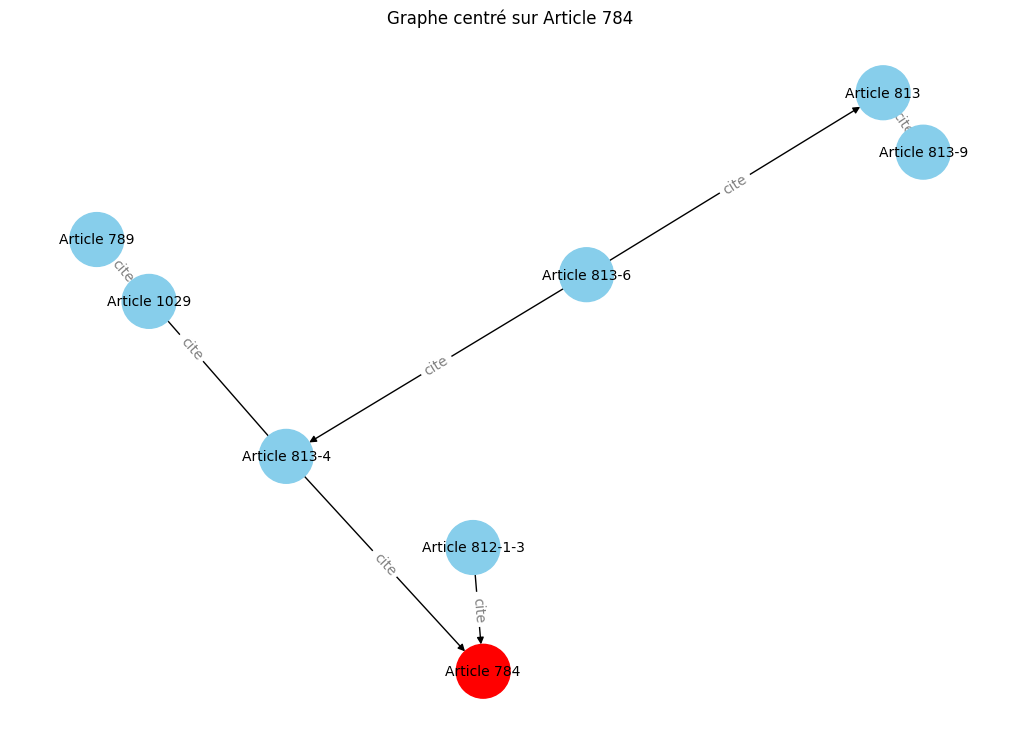

In [ ]:
visualize_article_graph(G, "Article 784", depth=4)
